In [3]:
import caffe
from caffe import layers as L
from caffe import params as P

import numpy as np
import scipy.misc

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

# simple conv

In [6]:
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    n.data = L.Input(input_param={'shape':{'dim':[1,1,5,5]}})
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=3, weight_filler=dict(type='xavier'))
    return n.to_proto()

with open('one_conv.prototxt', 'w') as f:
    f.write(str(custom_net(None, None)))
    
net = caffe.Net('one_conv.prototxt', caffe.TEST)   
print net.blobs['conv1'].data.shape
net.save('one_conv.caffemodel') 

(1, 3, 1, 1)


### load model

In [40]:
net = caffe.Net('one_conv.prototxt', 'one_conv.caffemodel', caffe.TEST)

im_input = np.array([[0.1, 0.2, 0.3, 0.4, 0.5],
                     [0.1, 0.2, 0.3, 0.4, 0.5],
                     [0.1, 0.2, 0.3, 0.4, 0.5],
                     [0.1, 0.2, 0.3, 0.4, 0.5],
                     [0.1, 0.2, 0.3, 0.4, 0.5]])
im_input = im_input.reshape((1, 1, 5, 5))
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
net.forward()

{'conv1': array([[[[ 0.09736425]],
 
         [[ 0.18508951]],
 
         [[-0.32927603]]]], dtype=float32)}

# simple network

In [12]:
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()

    n.data = L.Input(input_param={'shape':{'dim':[1,3,224,224]}})
    
    n.conv1 = L.Convolution(n.data, kernel_size=6,
                            num_output=48, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv2 = L.Convolution(n.pool1, kernel_size=5,
                            num_output=48, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv3 = L.Convolution(n.pool2, kernel_size=4,
                            num_output=48, weight_filler=dict(type='xavier'))
    
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv4 = L.Convolution(n.pool3, kernel_size=2,
                            num_output=48, weight_filler=dict(type='xavier'))
    n.pool4 = L.Pooling(n.conv4, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.fc1 = L.InnerProduct(n.pool4, num_output=10,
                           weight_filler=dict(type='xavier'))
        
    n.score = L.InnerProduct(n.fc1, num_output=5,
                             weight_filler=dict(type='xavier'))

    n.prob = L.Softmax(n.score)

    return n.to_proto()

with open('simple_softmax.prototxt', 'w') as f:
    f.write(str(custom_net(None, None)))

net = caffe.Net('simple_softmax.prototxt', caffe.TEST)
print net.blobs['conv1'].data.shape
net.save('simple_softmax.caffemodel') 

(1, 48, 219, 219)


### load model

In [39]:
net = caffe.Net('simple_softmax.prototxt', 'simple_softmax.caffemodel', caffe.TEST)

im = scipy.misc.imread('cat_244.png')
im = im.astype(np.float32) / 255.
im = np.transpose(im, (2, 0, 1))

im_input = im[None, :, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
net.forward()

{'prob': array([[ 0.10364529,  0.23115003,  0.08956085,  0.22188075,  0.3537631 ]], dtype=float32)}

# VGG16 Imagenet

In [1]:
import json
labels = json.load(open('label.json', 'r'))
labels = {int(k): v for k, v in labels.items()}

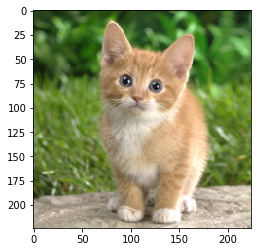

In [22]:
import matplotlib.pyplot as plt
im = scipy.misc.imread('cat_244.png')
plt.imshow(input_image)
plt.show()

In [25]:
net = caffe.Net('VGG_ILSVRC_16_layers_deploy.prototxt', 'VGG_ILSVRC_16_layers.caffemodel', caffe.TEST)

im = scipy.misc.imread('cat_244.png')
im = im[:, :, ::-1]  # RGB --> BGR
# im -= np.array([128, 128, 128], np.uint8)
im = im.astype(np.float32) / 255.
im = np.transpose(im, (2, 0, 1))

im_input = im[None, :, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
result = net.forward()
prediction = result['prob']

idx = np.argmax(prediction)
print '{}: {} ({})'.format(idx, labels[idx], prediction[0, idx])

258: Samoyed, Samoyede (0.0568021200597)


In [27]:
net = caffe.Classifier('VGG_ILSVRC_16_layers_deploy.prototxt', 'VGG_ILSVRC_16_layers.caffemodel',
                       # mean=np.load(self.mean_image).mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(224, 224))
input_image = caffe.io.load_image('cat_244.png')
prediction = net.predict([input_image], oversample=False)

idx = np.argmax(prediction)
print '{}: {} ({})'.format(idx, labels[idx], prediction[0, idx])

285: Egyptian cat (0.336683869362)
